In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
basepath = os.path.expanduser('../')

## Load Data

In [3]:
%%time

app_train = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_train.pkl'))
# app_test  = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_test.pkl'))

# bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/bureau.pkl'))
# bureau_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/bureau_balance.pkl'))
# prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/previous_application.pkl'))
# installments = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/installments_payments.pkl')) 
# pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/POS_CASH_balance.pkl'))
# credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/credit_card_balance.pkl'))

CPU times: user 31.3 ms, sys: 72.1 ms, total: 103 ms
Wall time: 416 ms


### Age

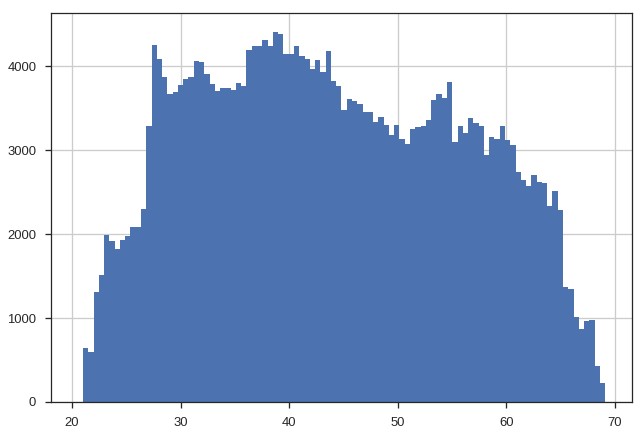

In [6]:
(-app_train.DAYS_BIRTH / 365).hist(bins=100);

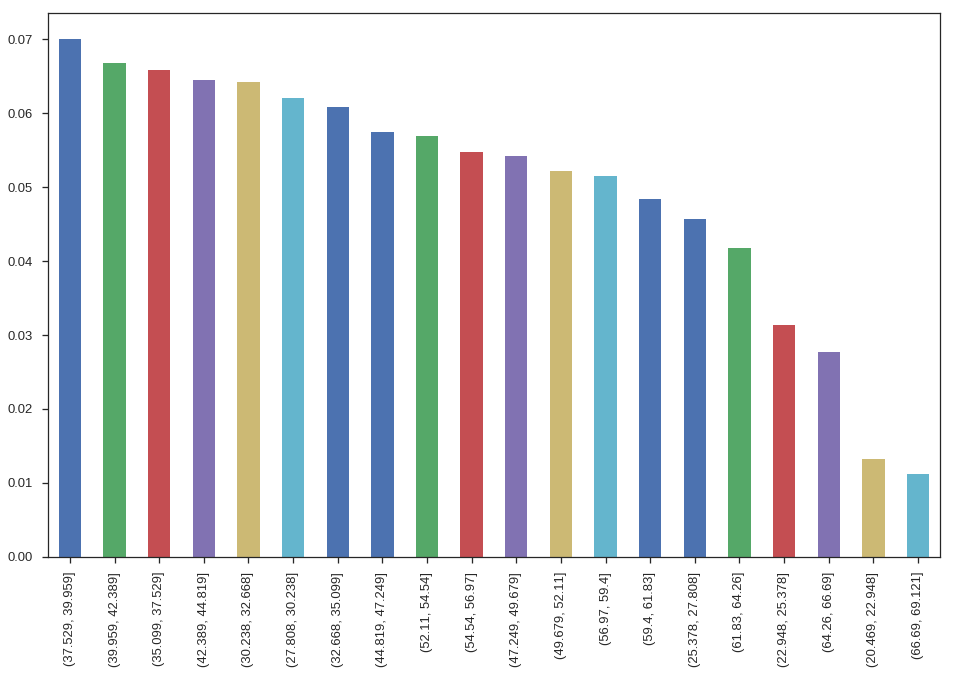

In [16]:
plt.figure(figsize=(16, 10))
pd.cut(-app_train.DAYS_BIRTH / 365, bins=20).value_counts(normalize=True).plot(kind='bar');

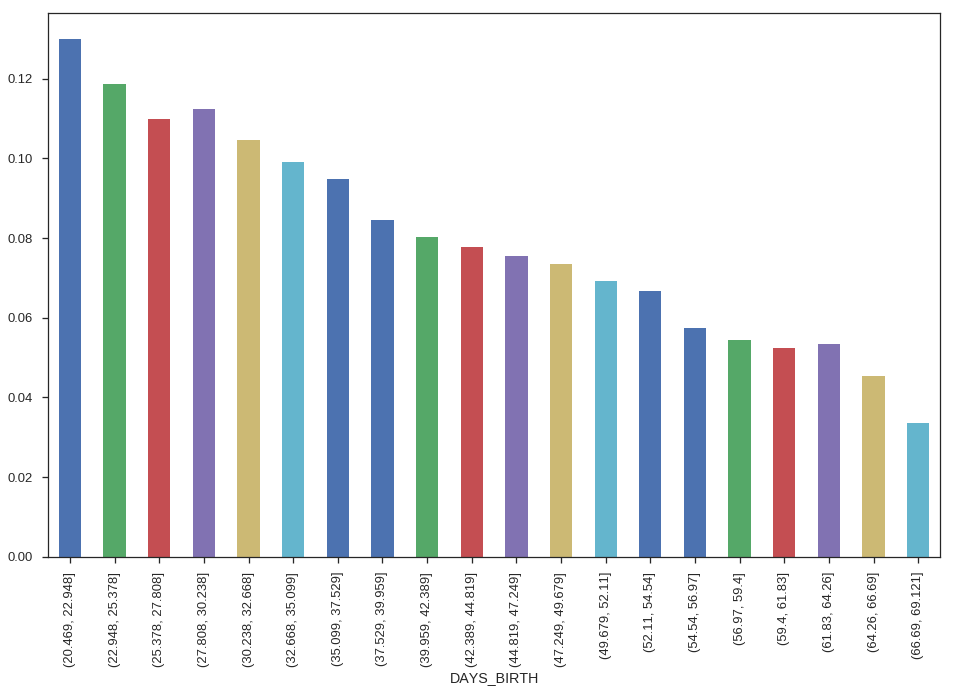

In [20]:
plt.figure(figsize=(16, 10))
app_train.groupby(pd.cut(-app_train.DAYS_BIRTH / 365, bins=20))['TARGET'].mean().plot(kind='bar');

### Days employed

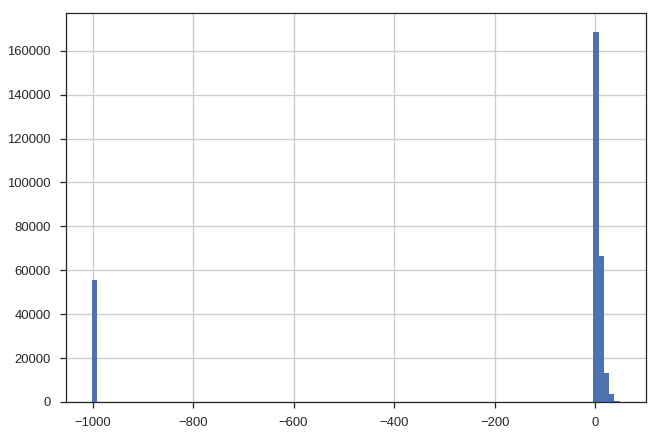

In [4]:
(-app_train.DAYS_EMPLOYED / 365).hist(bins=100);

** Interesting, missing values are filled by 365243for days employed **

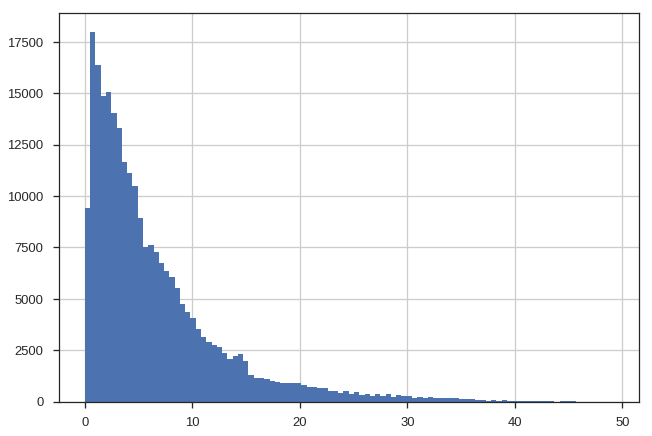

In [8]:
(-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365).hist(bins=100);

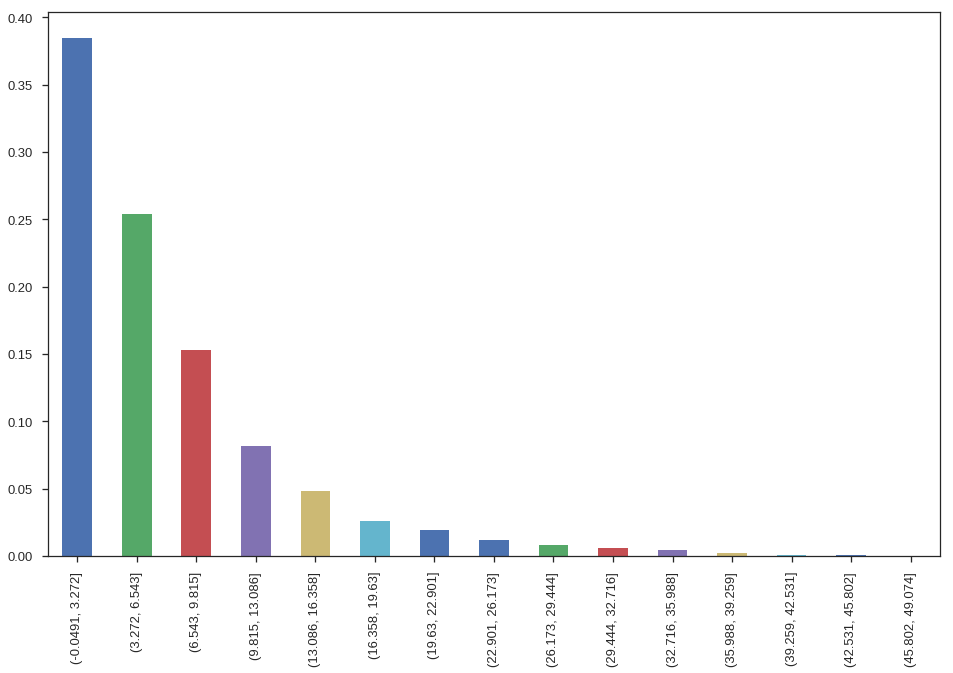

In [11]:
plt.figure(figsize=(16, 10))
pd.cut((-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365), bins=15).value_counts(normalize=True).plot(kind='bar');

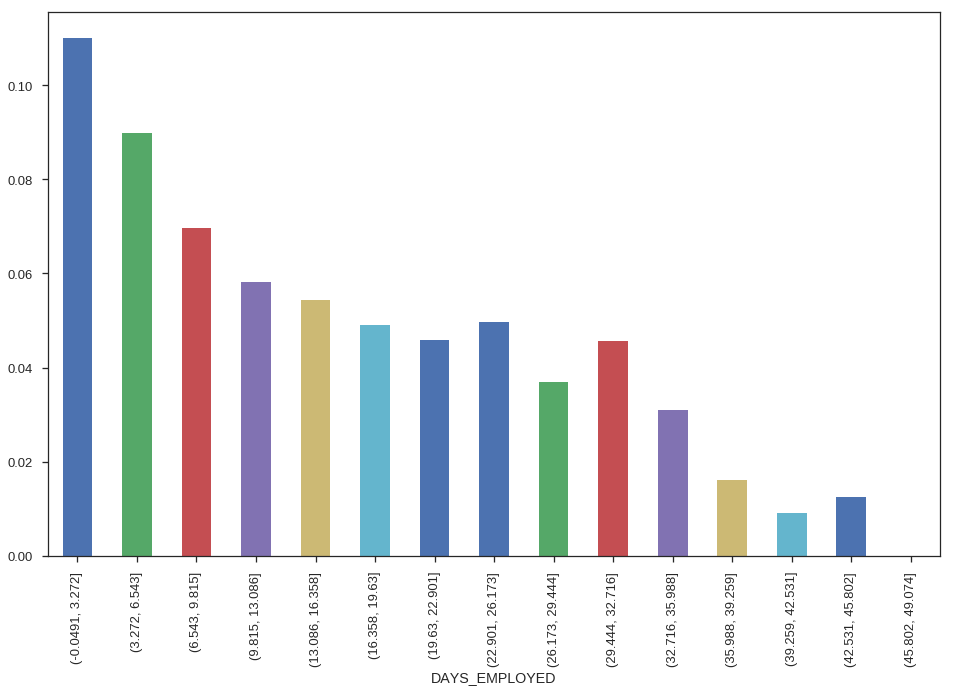

In [12]:
plt.figure(figsize=(16, 10))
app_train.groupby(pd.cut((-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365), bins=15))['TARGET'].mean().plot(kind='bar');

### Combine Age and days employed

In [18]:
age_categorical = pd.cut(-app_train.DAYS_BIRTH / 365, bins=20)
emp_categorical = pd.cut((-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365), bins=15)

age_emp_categorical = age_categorical.astype(np.str) + '_' + emp_categorical.astype(np.str)

In [21]:
ss = pd.crosstab(age_emp_categorical, app_train.TARGET).sort_values(by=0, ascending=False)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss)

del ss
gc.c

TARGET,0.0,1.0
row_0,,
"(59.4, 61.83]_nan",10377,596
"(61.83, 64.26]_nan",10072,588
"(56.97, 59.4]_nan",9289,504
"(27.808, 30.238]_(-0.0491, 3.272]",8131,1150
"(30.238, 32.668]_(-0.0491, 3.272]",7484,1064
"(64.26, 66.69]_nan",7183,344
"(25.378, 27.808]_(-0.0491, 3.272]",7042,946
"(37.529, 39.959]_(-0.0491, 3.272]",6782,824
"(54.54, 56.97]_nan",6775,395


### Compare refused previous applications with current application.

In [22]:
# How many current applicants have data for previous applications
res = app_train.loc[:, ['SK_ID_CURR']]\
               .merge(prev_app.loc[:, ['SK_ID_CURR', 'NAME_CONTRACT_STATUS']], how='left')
    
print('{} fraction of people have data for previous applications'.format(res[res.NAME_CONTRACT_STATUS.notnull()].shape[0] / len(res)))

0.9884949533442179 fraction of people have data for previous applications


98.9% of people have made an application to Home Credit prior to the current application.

In [23]:
# How many of them have had their application refused in the past
res = app_train.loc[:, ['SK_ID_CURR']]\
               .merge(prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Refused', ['SK_ID_CURR', 'NAME_CONTRACT_STATUS']], how='left')

print('{} fraction of people who have had their application refused in the past'.format(res[res.NAME_CONTRACT_STATUS.notnull()].shape[0] / len(res)))

0.5421701387738148 fraction of people who have had their application refused in the past


54.21 % of people have had their application refused in the past.

In [30]:
refused_mask  = (prev_app.NAME_CONTRACT_STATUS == 'Refused')
approved_mask = (prev_app.NAME_CONTRACT_STATUS == 'Approved')

In [31]:
prev_app.loc[refused_mask, 'NAME_CONTRACT_TYPE'].value_counts(normalize=True)

Cash loans         0.570831
Consumer loans     0.258654
Revolving loans    0.170408
XNA                0.000107
Name: NAME_CONTRACT_TYPE, dtype: float64

In [32]:
prev_app.loc[approved_mask, 'NAME_CONTRACT_TYPE'].value_counts(normalize=True)

Consumer loans     0.604245
Cash loans         0.301452
Revolving loans    0.094302
XNA                0.000000
Name: NAME_CONTRACT_TYPE, dtype: float64

### Annuity

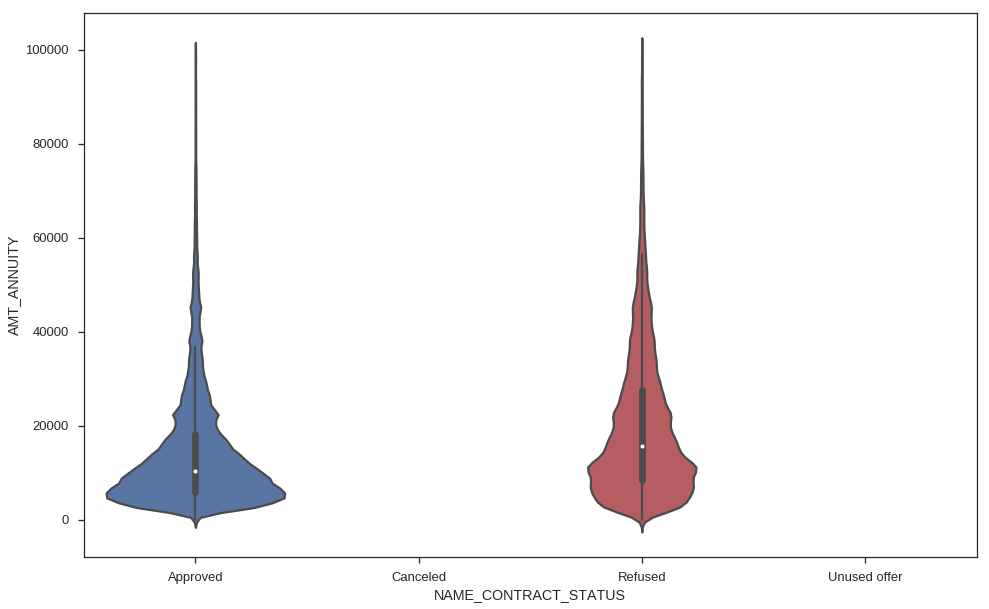

In [43]:
plt.figure(figsize=(16, 10))
sns.violinplot(y='AMT_ANNUITY', x='NAME_CONTRACT_STATUS', 
               data=prev_app.loc[(prev_app.NAME_CONTRACT_STATUS.isin(['Approved', 'Refused'])) &\
                                 (prev_app.AMT_ANNUITY < 100000)
                                ]);

#### Amount Credit

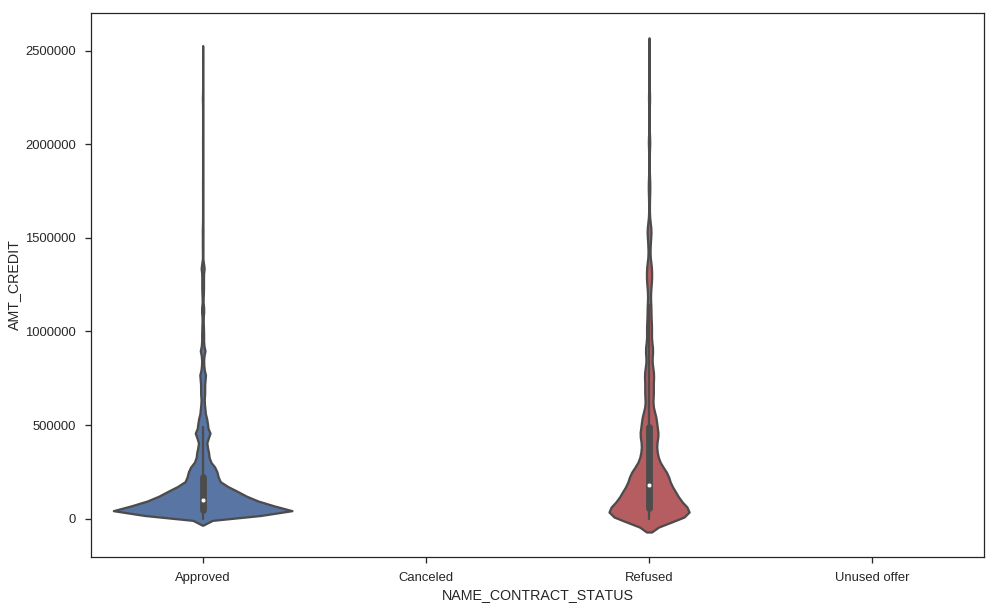

In [45]:
plt.figure(figsize=(16, 10))
sns.violinplot(y='AMT_CREDIT', x='NAME_CONTRACT_STATUS', 
               data=prev_app.loc[(prev_app.NAME_CONTRACT_STATUS.isin(['Approved', 'Refused'])) &\
                                 (prev_app.AMT_CREDIT < 2500000)
                                ]);

### Payment Rate

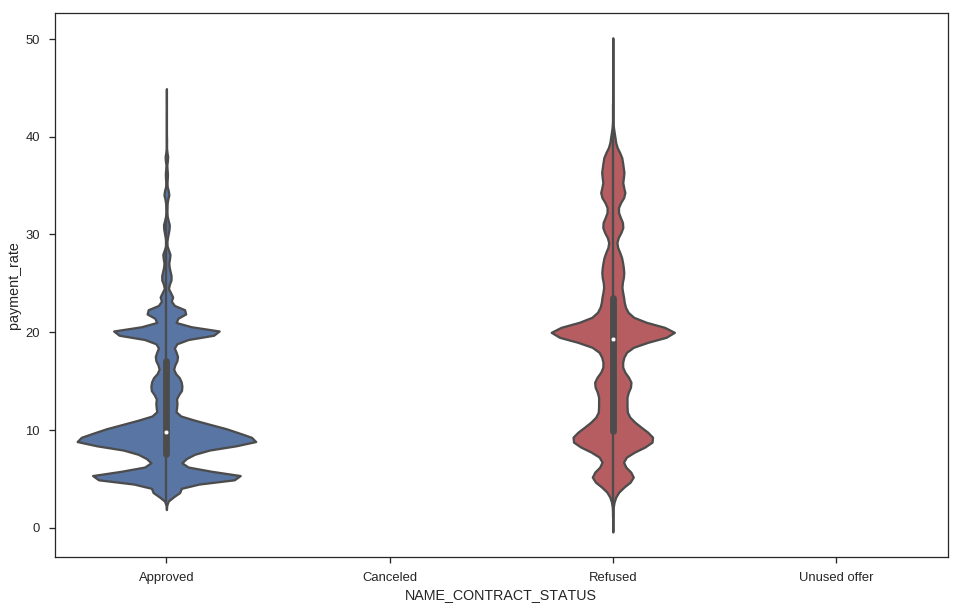

In [48]:
plt.figure(figsize=(16, 10))
df = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS.isin(['Approved', 'Refused']))]
df.loc[:, 'payment_rate'] = (df.AMT_CREDIT / df.AMT_ANNUITY).replace([np.inf, -np.inf], np.nan)

sns.violinplot(y='payment_rate', x='NAME_CONTRACT_STATUS', 
               data=df[df.payment_rate < 50]);

### Down Payment

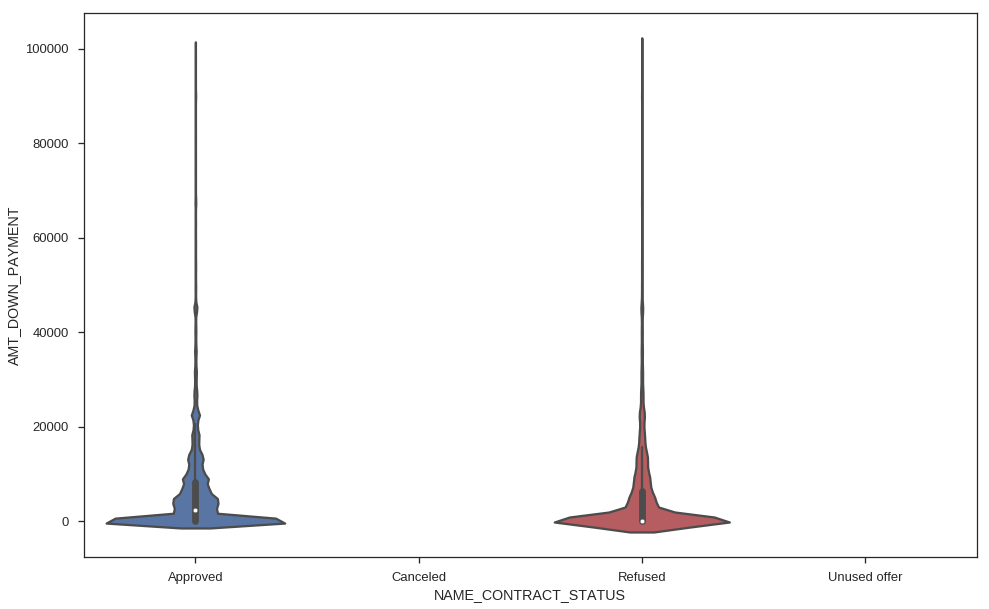

In [56]:
plt.figure(figsize=(16, 10))
sns.violinplot(y='AMT_DOWN_PAYMENT', x='NAME_CONTRACT_STATUS', 
               data=prev_app.loc[(prev_app.NAME_CONTRACT_STATUS.isin(['Approved', 'Refused'])) &\
                                 (prev_app.AMT_DOWN_PAYMENT < 100000)
                                ]);

### Goods price

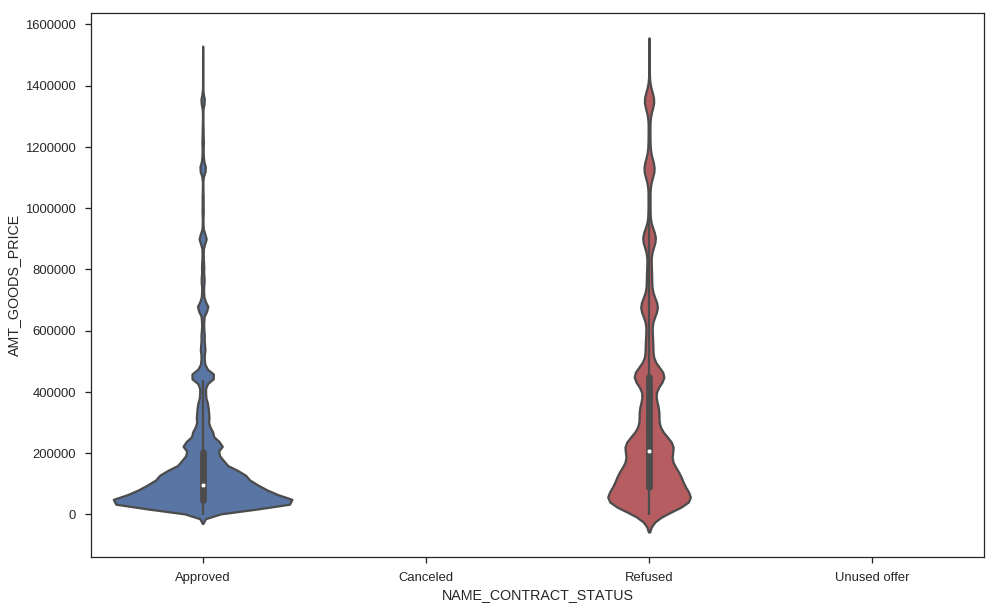

In [58]:
plt.figure(figsize=(16, 10))
sns.violinplot(y='AMT_GOODS_PRICE', x='NAME_CONTRACT_STATUS', 
               data=prev_app.loc[(prev_app.NAME_CONTRACT_STATUS.isin(['Approved', 'Refused'])) &\
                                 (prev_app.AMT_GOODS_PRICE < 1500000)
                                ]);

### Difference between payment rate between approved and refused applications for applicants.

In [79]:
r1 = (prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', 'AMT_ANNUITY'] /\
     prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', 'AMT_CREDIT']).replace([np.inf, -np.inf], np.nan)
r1 = r1.reset_index()
r1.loc[:, 'index'] = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', 'SK_ID_CURR'].values
r1 = r1.rename(columns={'index': 'SK_ID_CURR',
                        0: 'payment_rate'
                       })
r1 = r1.groupby('SK_ID_CURR')['payment_rate'].max()

r2 = (prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Refused', 'AMT_ANNUITY'] /\
      prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Refused', 'AMT_CREDIT']).replace([np.inf, -np.inf], np.nan)

r2 = r2.reset_index()
r2.loc[:, 'index'] = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Refused', 'SK_ID_CURR'].values
r2 = r2.rename(columns={'index': 'SK_ID_CURR',
                        0: 'payment_rate'
                       })
r2 = r2.groupby('SK_ID_CURR')['payment_rate'].min()

res = r1.subtract(r2, fill_value=np.nan)
res = app_train.SK_ID_CURR.map(res)

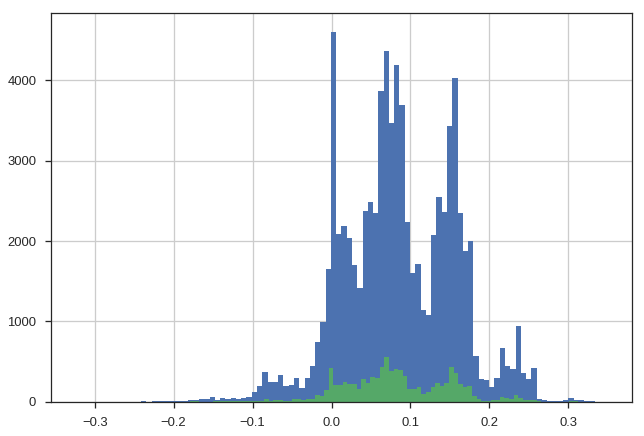

In [81]:
res[app_train.TARGET == 0].hist(bins=100)
res[app_train.TARGET == 1].hist(bins=100);

### Difference between credit amount of approved and refused applications.

In [89]:
r1 = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR', 'AMT_CREDIT']]
r1 = r1.groupby('SK_ID_CURR')['AMT_CREDIT'].max()

r2 = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Refused', ['SK_ID_CURR', 'AMT_CREDIT']]
r2 = r2.groupby('SK_ID_CURR')['AMT_CREDIT'].min()

res = r1.subtract(r2, fill_value=np.nan)
res = app_train.SK_ID_CURR.map(res)

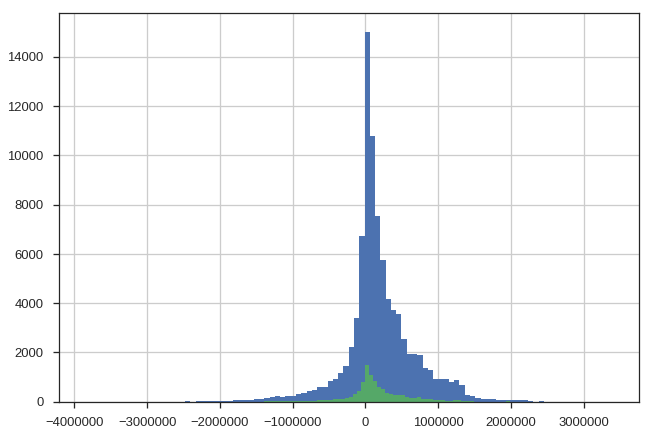

In [90]:
res[app_train.TARGET == 0].hist(bins=100)
res[app_train.TARGET == 1].hist(bins=100);

### Difference between goods price of approved and refused applications.

In [91]:
r1 = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR', 'AMT_GOODS_PRICE']]
r1 = r1.groupby('SK_ID_CURR')['AMT_GOODS_PRICE'].max()

r2 = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Refused', ['SK_ID_CURR', 'AMT_GOODS_PRICE']]
r2 = r2.groupby('SK_ID_CURR')['AMT_GOODS_PRICE'].min()

res = r1.subtract(r2, fill_value=np.nan)
res = app_train.SK_ID_CURR.map(res)

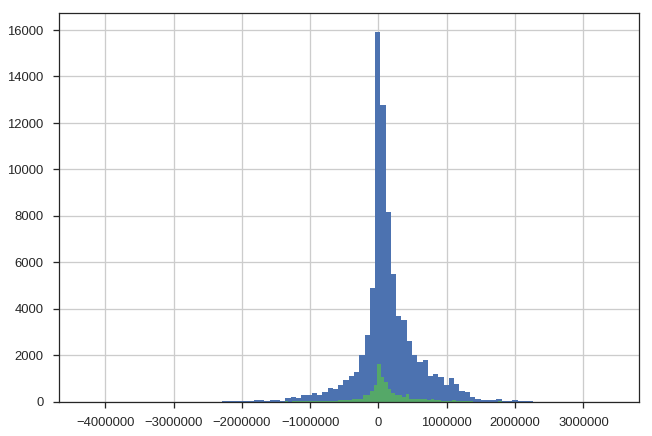

In [96]:
res[app_train.TARGET == 0].hist(bins=100)
res[app_train.TARGET == 1].hist(bins=100)

### Previous application and Installments

In [81]:
# applications currently running
res = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
                   (prev_app.DAYS_TERMINATION > 0)
                  ]

res = res.loc[:, ['SK_ID_CURR', 'SK_ID_PREV']]\
         .merge(installments.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT']])
    
res.loc[:, 'diff'] = res.DAYS_INSTALMENT - res.DAYS_ENTRY_PAYMENT
res                = res.groupby('SK_ID_CURR')['diff'].max()
res                = app_train.SK_ID_CURR.map(res)

In [82]:
res[res.isnull()].shape[0] / len(res)

0.5601360601734572

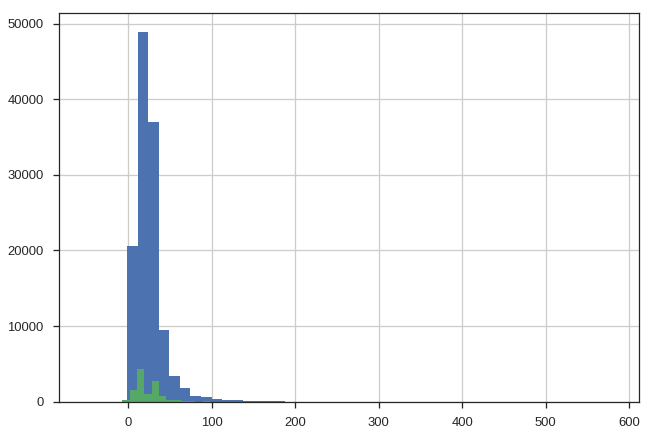

In [83]:
res[app_train.TARGET == 0].hist(bins=50)
res[app_train.TARGET == 1].hist(bins=50);

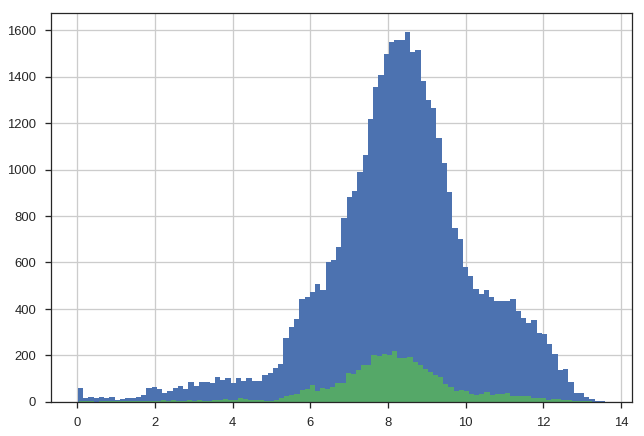

In [54]:
res[(res > 0) & (app_train.TARGET == 0)].map(np.log1p).hist(bins=100)
res[(res > 0) & (app_train.TARGET == 1)].map(np.log1p).hist(bins=100)

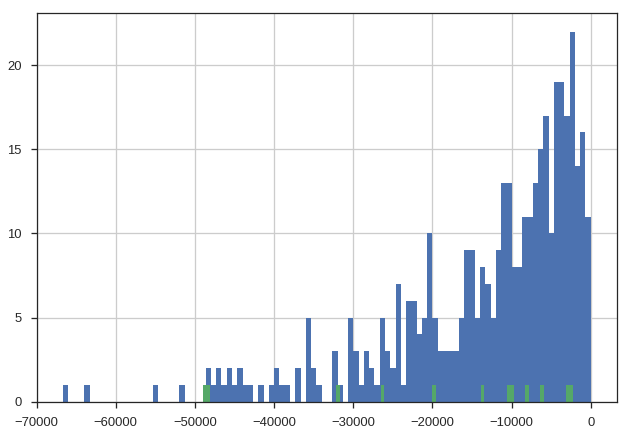

In [46]:
res[(res < 0) & (app_train.TARGET == 0)].hist(bins=100)
res[(res < 0) & (app_train.TARGET == 1)].hist(bins=100);

### Relationship between previous application and credit balance.

In [21]:
res = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR',
                                                         'SK_ID_PREV']]\
        .merge(credit_bal.loc[credit_bal.MONTHS_BALANCE > -12, 
                              ['SK_ID_CURR', 'SK_ID_PREV', 'CNT_DRAWINGS_ATM_CURRENT'
                              ]])
res  = res.groupby('SK_ID_CURR')['CNT_DRAWINGS_ATM_CURRENT'].sum()
res  = app_train.SK_ID_CURR.map(res)

In [22]:
res[res.isnull()].shape[0] / len(res)

0.7465651635226057

In [23]:
ss = pd.crosstab(res, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss)

del ss
gc.collect();

TARGET        0.0   1.0     ratio
SK_ID_CURR                       
0.0         48303  3380  0.065399
1.0          2682   289  0.097274
2.0          2332   282  0.107881
3.0          2133   266  0.110880
4.0          1866   248  0.117313
5.0          1656   281  0.145070
6.0          1422   272  0.160567
7.0          1341   222  0.142035
8.0          1196   212  0.150568
9.0          1070   169  0.136400
10.0          883   151  0.146035
11.0          759   130  0.146232
12.0          681   131  0.161330
13.0          530   105  0.165354
14.0          501   114  0.185366
15.0          381    89  0.189362
16.0          372    88  0.191304
17.0          335    63  0.158291
18.0          288    55  0.160350
19.0          236    49  0.171930
20.0          195    44  0.184100
21.0          181    40  0.180995
22.0          155    43  0.217172
23.0          151    30  0.165746
24.0          128    30  0.189873
25.0           88    26  0.228070
26.0           93    23  0.198276
27.0          